In [25]:
import os
import cv2
import time
import torch
import random
import torchvision
import numpy as np
from PIL import Image, ImageOps
from torchvision.transforms import transforms as transforms

#Very hacky fix to make matplotlib work on my pc
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
downloaded_dir = repo_dir + "downloaded-data/"
frames_save_dir = downloaded_dir + 'frames/'
images_save_dir = downloaded_dir + "saved-labels/"

if not os.path.exists(downloaded_dir):
    os.makedirs(downloaded_dir)
if not os.path.exists(images_save_dir):
    os.makedirs(images_save_dir)

def display_cv2_img(img):
    display_img = Image.fromarray(img[:,:,::-1])
    display(ImageOps.contain(display_img, (500, 500)))

labelled_filenames = os.listdir(images_save_dir)
img_num = 1
for filename in labelled_filenames:
    img_num = max(img_num, int(filename.split("_")[0])+1)
print(f"Starting on img_num: {img_num}")
start_num = img_num
t_start = time.time()

images_left_path = f'{downloaded_dir}/images_left.txt'
#check if exists
if not os.path.exists(images_left_path):
    image_paths = [frames_save_dir + filename for filename in sorted(os.listdir(frames_save_dir))]
    random.shuffle(image_paths)
    with open(images_left_path, 'w') as f:
        f.write("\n".join(image_paths))

    with open(f'{downloaded_dir}/backup.txt', 'w') as f:
        f.write("\n".join(image_paths))

def label_golf_img(img, grip, club, line_width = 2):
    box_buffer = max(img.shape[:2])//20
    box_cords = [
        max(min(grip[0], club[0])-box_buffer, 2),
        max(min(grip[1], club[1])-box_buffer, 2), #top left cord
        min(max(grip[0], club[0])+box_buffer, img.shape[1]-2), # shape[0] is y
        min(max(grip[1], club[1])+box_buffer, img.shape[0]-2)] # bottom right cord

    cv2.circle(img, grip[:2], 5, (255,0,255), -1)
    cv2.circle(img, club[:2], 5, (255,0,255), -1)
    cv2.line(img, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(img, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return img

def click_event_label(event, x, y, flags, params):
        # checking for left mouse clicks or right mouse clicks
        if event==cv2.EVENT_RBUTTONDOWN:
            global skip
            skip = True
        if event == cv2.EVENT_LBUTTONDOWN:
            global golf_club_coordinates
            golf_club_coordinates.append([int(x),int(y)])

def click_event_save(event, x, y, flags, params):
    # checking for left mouse clicks or right mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
        global save
        save = True
    elif event == cv2.EVENT_RBUTTONDOWN:
        global redo
        redo = True


max_height, max_width = 720, 1225

loop = True
while loop:
    #really images will be filename and file will be loaded in first name
    #check if file exists
    with open(images_left_path, 'r') as fin:
        data = fin.read().splitlines(True)
    filepath = data[0][:-1] # removing \n at end
    img = cv2.imread(filepath)

    height, width = img.shape[:2]
    display_img = cv2.copyMakeBorder(img, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)

    ### Labelled images in window
    golf_club_coordinates = []
    skip = False
        
    cv2.imshow('image', display_img)
    cv2.setWindowProperty('image', cv2.WND_PROP_TOPMOST, 1)
    cv2.setMouseCallback('image', click_event_label)
    while len(golf_club_coordinates) != 2:
        if skip:
            break
        k = cv2.waitKey(100)

        if k == 27:
            print("Ending loop.")
            loop = False
            cv2.destroyWindow('image') #make sure window closes cleanly
            break
    if not loop:
        break

    if skip:
        with open(images_left_path, 'r') as fin:
            data = fin.read().splitlines(True)
        with open(images_left_path, 'w') as fout:
            fout.writelines(data[1:])
        continue
    
    ### Annotate labels on images
    grip, club = golf_club_coordinates
    labelled = label_golf_img(img.copy(), grip, club)
    display_img = cv2.copyMakeBorder(labelled, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)
    save = False
    redo = False
    # display_cv2_img(img)
    # display_cv2_img(labelled)
    # display_cv2_img(display_img)


    cv2.imshow('image', display_img)
    cv2.setWindowProperty('image', cv2.WND_PROP_TOPMOST, 1)
    cv2.setMouseCallback('image', click_event_save)
    while not (save or redo):
        k = cv2.waitKey(100)
        if k == 27:
            print("Ending loop.")
            loop = False
            cv2.destroyWindow('image') #make sure window closes cleanly
            break
    if not loop:
        break
    
    if save:
        save_filename = f"{img_num}_"
        for x, y in [grip] + [club]:
            save_filename += f"{x}-{y}-"
        save_filename = save_filename[:-1] +  "_.png"
        save_path = images_save_dir + save_filename
        print("Saving", save_path)
        cv2.imwrite(save_path, img)

        img_num+=1
        with open(images_left_path, 'r') as fin:
            data = fin.read().splitlines(True)
        with open(images_left_path, 'w') as fout:
            fout.writelines(data[1:])
    # else:
    #     print("redoing image")

print(f"Ending on img_num: {img_num} | Labelled: {img_num - start_num} | Time taken: {time.time()-t_start:.2f}s")

Starting on img_num: 1000
Saving c:/Users/James/git/3dGolfPoseDetection/downloaded-data/saved-labels/1000_385-426-202-611_.png
Ending loop.
Ending on img_num: 1001 | Labelled: 1 | Time taken: 11.48s


batch[0] list containing 20 tensors of shape torch.Size([3, 720, 1225]):
batch[1] list containing 20 of the following:
'boxes': torch.Size([1, 4]), torch.float32
'labels': torch.Size([1]), torch.int64
'keypoints': torch.Size([1, 2, 3]), torch.float32


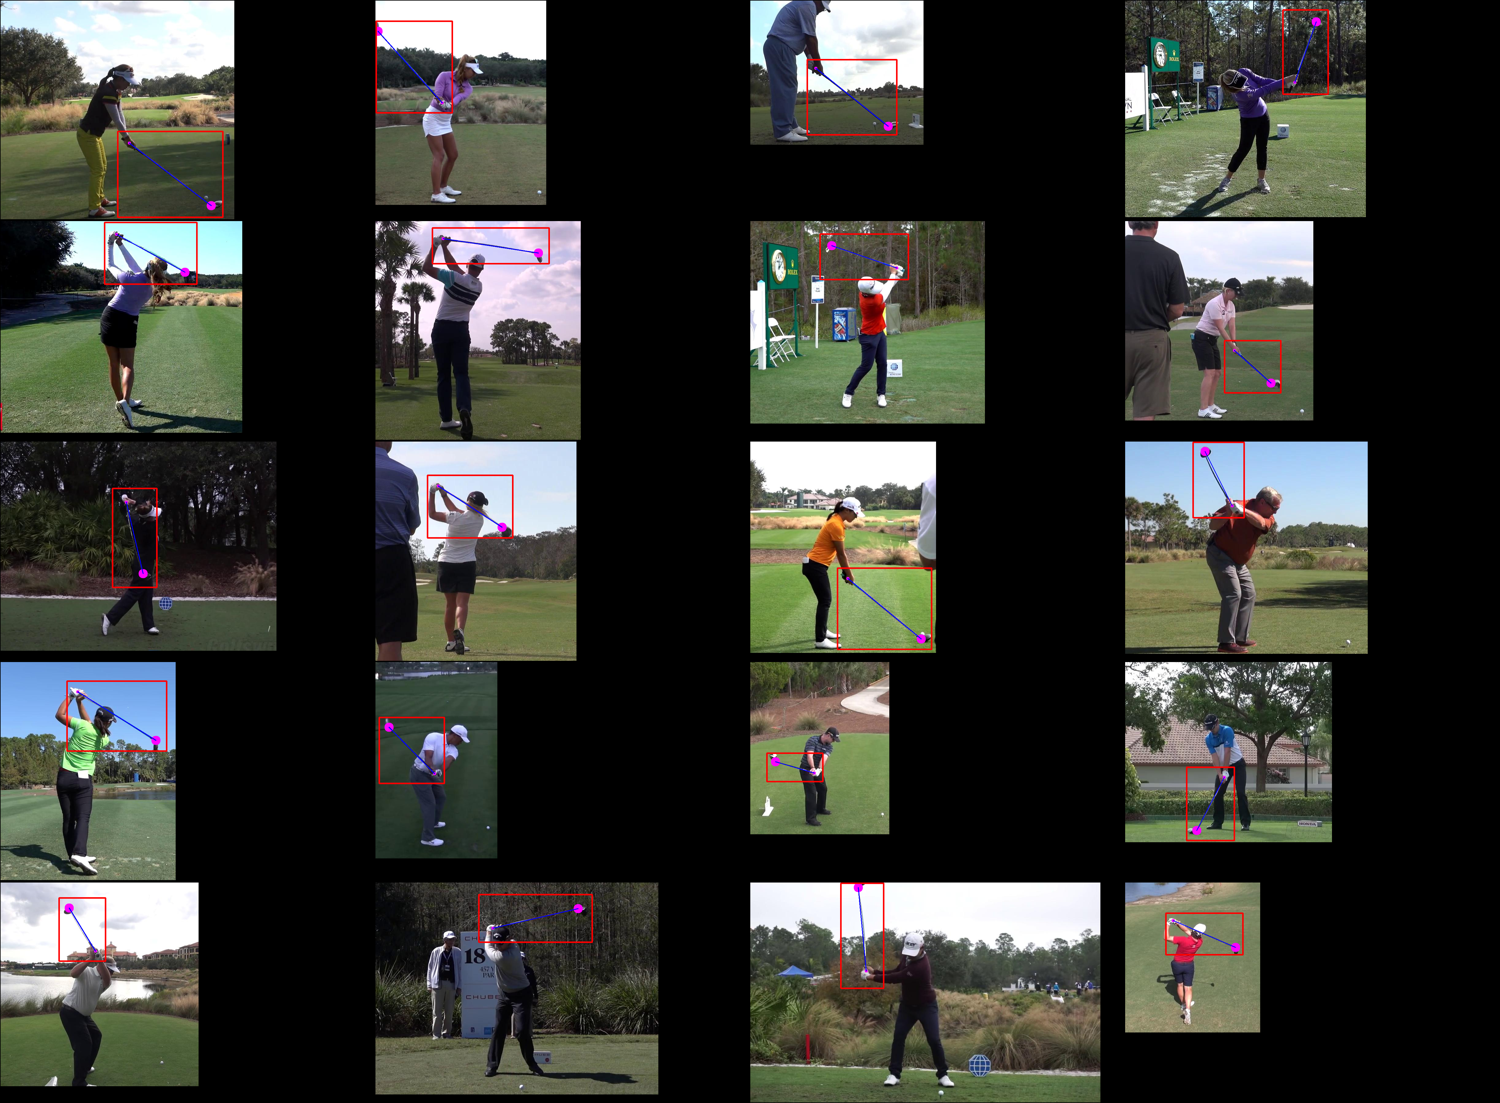

In [17]:
def label_img(img, grip, club, box_cords, line_width=4):
    cv2.circle(img, grip[:2], 5, (255,0,255), -1)
    cv2.circle(img, club[:2], 15, (255,0,255), -1)
    cv2.line(img, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(img, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return img

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, save_dir, filenames, device = torch.device("cpu"), annotate = False, padding = False):
        self.save_dir = save_dir
        self.filenames = filenames
        self.annotate = annotate
        self.device = device
        self.img_transforms = transforms.ToTensor()
        self.padding = padding

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img = cv2.imread(self.save_dir+filename)
        cords = [int(x) for x in filename.split("_")[1].split("-")]
        grip, club = cords[:2], cords[2:]
        box_buffer = max(img.shape[:2])//20
        box_cords = [
            max(min(grip[0], club[0])-box_buffer, 2),
            max(min(grip[1], club[1])-box_buffer, 2), #top left cord
            min(max(grip[0], club[0])+box_buffer, img.shape[1]-2), # shape[0] is y
            min(max(grip[1], club[1])+box_buffer, img.shape[0]-2)] # bottom right cord
        
        if self.annotate:
            img = label_img(img, grip, club, box_cords)
        
        if self.padding:
            max_height, max_width = 720, 1225
            height, width = img.shape[:2]
            img = cv2.copyMakeBorder(img, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        
        grip.append(1.)
        club.append(1.)
        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64).to(self.device)
        target["keypoints"] = torch.Tensor([grip, club]).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)

        img = Image.fromarray(img[:, :, ::-1])
        img = self.img_transforms(img).to(self.device)

        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

batch_size = 20

filenames = sorted(os.listdir(images_save_dir))

dataset = GolfDataset(images_save_dir, filenames, device = device, annotate=True, padding = True)
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))

print(f"batch[0] list containing {len(batch[0])} tensors of shape {batch[0][0].shape}:")
print(f"batch[1] list containing {len(batch[1])} of the following:")
for key in batch[1][0]:
    print(f"'{key}': {batch[1][0][key].shape}, {batch[1][0][key].dtype}")

display_img = Image.fromarray((torchvision.utils.make_grid(torch.stack(batch[0],dim=0).cpu(), nrow = 4).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (1500, 1500)))